In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from stable_baselines3 import SAC
from KSEnv import KS_Env
import yaml
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
def make_env(**kwargs):
    base_args = {
        'L':7,
        'actuator_loss_weight':1,
        'seed':None,
        'device':"cpu",
        'N':32,
        'dt':0.01,
        'max_steps':2500,
        'u0':None,
        'lim':1,
        'plot':True,
        'verbose':True,
        'controller':'nonlin',
        'sees_state':True,
        'observation_type':'state',
        'reward_type':'trivial',
        'pullback_state':True,
        'noise':0,
        'initial_amp': 0.1,
        'continuous':False
    }

    base_args.update(kwargs)

    return KS_Env(**base_args)

In [5]:
def test(model_path, env_path, num_episodes=10, plot=True, unforced=True):
    
    with open(env_path, 'r') as f:
        config = yaml.safe_load(f)
    env_args = config['env']
    env_args['plot'] = plot
    env_args['actuator_loss_weight'] = 0.0


    env = make_env(**env_args)
    model = SAC.load(model_path, env=env)    

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=num_episodes, deterministic=True)

    steps = env_args['max_steps']

    if unforced:
        env_args2 = env_args.copy()
        env_args2['controller'] = 'unforced'

        env2 = make_env(**env_args2)
        model2 = SAC.load(model_path, env=env2)

        mean_reward2, std_reward2 = evaluate_policy(model2, env2, n_eval_episodes=num_episodes, deterministic=True)

    steps = env_args['max_steps']

    print(f"Mean reward: {mean_reward/steps}, Std reward: {std_reward/steps}")
    if unforced:
        print(f"Unforced mean reward: {mean_reward2/steps}, Std reward: {std_reward2/steps}")
    if env_args['controller'] == 'fully_linear':
        K = model.actor.mu.weight.data.cpu().numpy()
        np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=4)
        print(f"Controller gain matrix K:\n{K}")


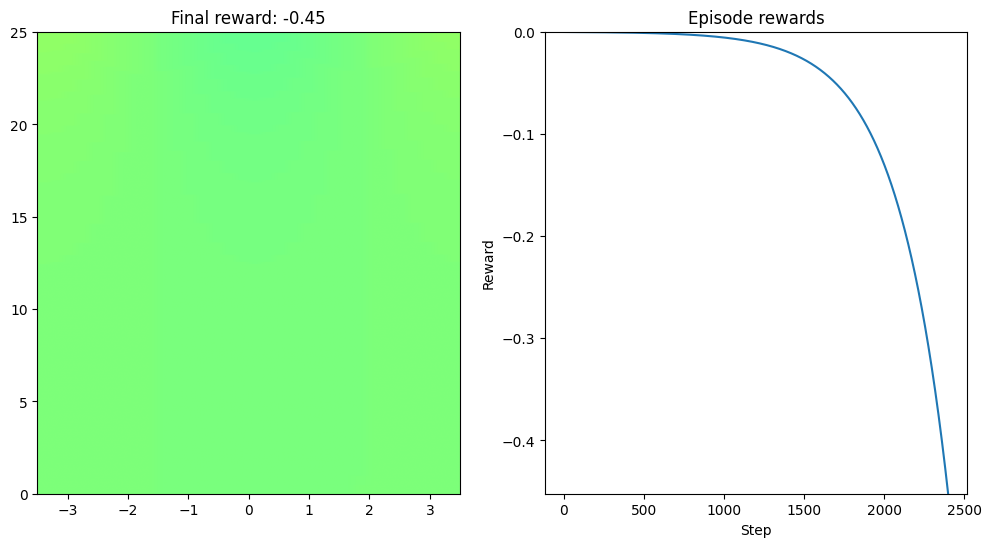

Mean reward: -0.1676047830340998, Std reward: 0.2572086885221845
Unforced mean reward: -0.18284020838408482, Std reward: 0.19667120984090342
Controller gain matrix K:
[[ 0.1948 -0.0818 -0.1604 -0.1672 -0.5323 -0.3589 -0.5757 -0.4892 -0.0774  0.5627  0.5735  0.4437  0.3936  0.1525  0.108   0.0134 -0.0283 -0.1305 -0.0443 -0.2045 -0.3737 -0.4499 -0.3987 -0.4727  0.0743  0.3018  0.3978  0.3862  0.1126  0.3797  0.2881  0.3529]
 [ 0.1687 -0.1253 -0.1649 -0.1241  0.0737 -0.1482 -0.0689 -0.2321 -0.9429  0.0747  0.2497  0.0866 -0.0414  0.1139 -0.0918  0.0416 -0.066  -0.0341 -0.1834 -0.0953  0.093  -0.027   0.2254  0.2452 -0.6485 -0.1863  0.0253 -0.0093 -0.1472  0.1168  0.1395  0.207 ]
 [-0.1129  0.0561  0.1832  0.3085  0.2342  0.3164  0.5931  0.4775 -2.4235 -0.5566 -0.4616 -0.4185 -0.309  -0.1847 -0.3267  0.0345 -0.0809 -0.0083  0.2009  0.2103  0.3809  0.1983  0.1545  0.4378  0.5025 -0.2534 -0.2868 -0.4644 -0.2702 -0.2165 -0.309  -0.1906]
 [ 0.1888  0.1002 -0.0842 -0.1487 -0.0173 -0.2822 -0.198

In [7]:
K = test('runs/linear_ens0.zip', 'configs/config_linear.yaml', num_episodes=10, plot=True)

In [6]:
env2 = make_env(observation_type='state_plus_time')
model2 = SAC.load("runs/reward_time/controller_nonlin/observation_state_plus_time/L_11.6_gamma_0.99_buffer_200000_lim_1.0/sac_ks_final.zip", env=env2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


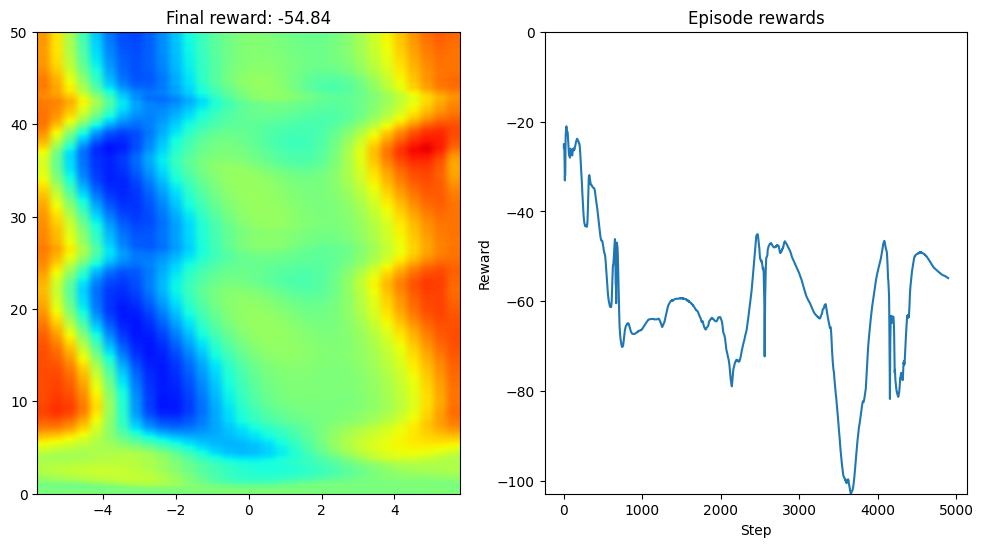

Mean reward: -11.157510997088 +/- 1.329493978960719


In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model2, model2.get_env(), n_eval_episodes=5)
print(f"Mean reward: {mean_reward/25000} +/- {std_reward/25000}")

In [12]:
env3 = make_env(L=7, controller='unforced')
model3 = SAC.load("runs/reward_trivial/controller_nonlin/observation_state/L_7_gamma_0.99_buffer_200000_lim_1.0/sac_ks_final.zip", env=env3)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


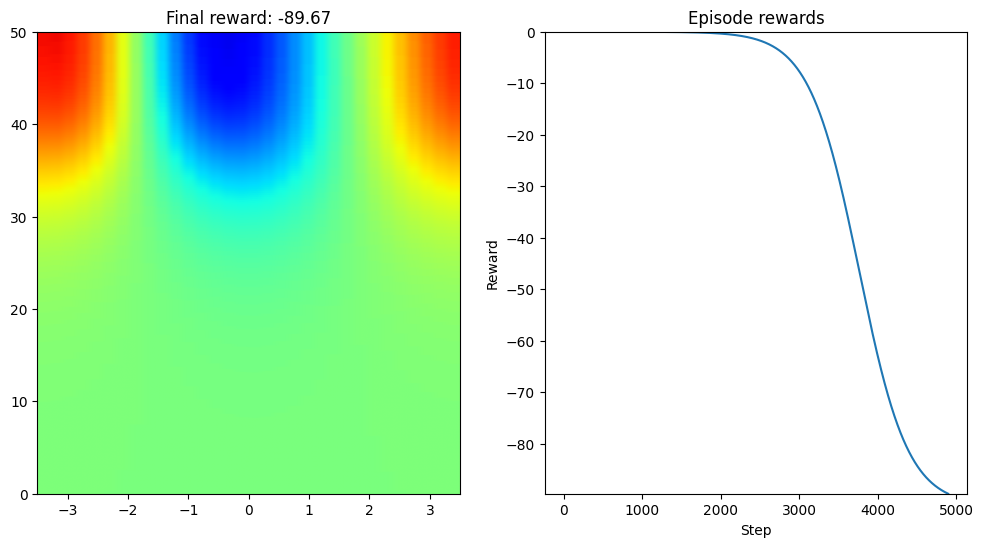

Mean reward: -3.606873730648 +/- 1.6917054892673928


In [14]:
from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model3, model3.get_env(), n_eval_episodes=5)
print(f"Mean reward: {mean_reward/25000} +/- {std_reward/25000}")